In [1]:
from utils import *
import pickle

In [2]:
class PointwiseLinear(torch.nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim):
        super().__init__()
        # 1 is for broadcasting
        self.W1 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, input_feature_dim))
        self.W2 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, input_feature_dim // 2))
        self.W3 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, input_feature_dim // 4))
#         self.W1 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, input_feature_dim))
#         self.W2 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, output_feature_dim * 4))
#         self.W3 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, output_feature_dim * 2))
        
        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)
        torch.nn.init.xavier_uniform_(self.W3)
        
        self.fc1 = torch.nn.Linear(input_feature_dim, input_feature_dim // 2)
        self.fc2 = torch.nn.Linear(input_feature_dim // 2, input_feature_dim // 4)
        self.fc3 = torch.nn.Linear(input_feature_dim // 4, input_feature_dim // 8)
#         self.fc1 = torch.nn.Linear(input_feature_dim, output_feature_dim * 4)
#         self.fc2 = torch.nn.Linear(output_feature_dim * 4, output_feature_dim * 2)
#         self.fc3 = torch.nn.Linear(output_feature_dim * 2, output_feature_dim)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.W1 * x) #().mean(dim=(-2, -1))
        out = self.fc1(out)
        out = self.relu(self.W2 * out)
        out = self.fc2(out)
        out = self.relu(self.W3 * out)
        out = (self.fc3(out)).mean(dim=(-2, -1))
        
        return out

In [3]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(
            16,
            self.hidden_size,
            self.num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )
        
        self.feature_extractor = PointwiseLinear(self.input_size, 16)
        self.fc_1 = nn.Linear(self.hidden_size + 9, self.hidden_size)
        
        #TODO: reduce the size of the dense net below
        self.fc_2 = nn.Sequential(
            nn.Linear(self.hidden_size // 1, self.hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(self.hidden_size // 2),
            nn.Dropout1d(0.05),
            nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.05),
            nn.Linear(self.hidden_size // 4, self.hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.05),
            nn.Linear(self.hidden_size // 8, self.output_size),
        )


    def forward(self, x, x_target):
        
        # B x T x N x F
        
        B = len(x)
        T = len(x[0])
        
        features = []
        
        for i in range(B):
            
            time_features = []
            
            #TODO: do not loop over time axis, pad the N axis :D
            for j in range(T):
                extracted_features = self.feature_extractor(torch.from_numpy(x[i][j].astype(np.float32)).to(dtype=torch.float32, device=DEVICE))
                time_features.append(extracted_features)
            
            time_features = torch.stack(time_features, dim=0)
            features.append(time_features)
        
        features = torch.stack(features, dim=0)
        lstm_features, _ = self.lstm(features)
        lstm_features = lstm_features[:, -1, ...]
        
        x_target = torch.from_numpy(np.stack(x_target).astype(np.float32)).to(dtype=torch.float32, device=DEVICE)
        combined_features = torch.cat([lstm_features, x_target], dim=-1)
            
        
        out = self.fc_1(combined_features)
        out = self.fc_2(out)
        
        return out

In [4]:
model = LSTMModel(input_size=78, hidden_size=512, num_layers=5, output_size=1).to(DEVICE)

In [5]:
with open('./data/X_train_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    X_train = pickle.load(file)
    
with open('./data/x_train_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    x_train = pickle.load(file)
    
with open('./data/y_train_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    y_train = pickle.load(file)    

In [6]:
with open('./data/X_val_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    X_val = pickle.load(file)
    
with open('./data/x_val_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    x_val = pickle.load(file)
    
with open('./data/y_val_lstm_new_arch_new_algo_200.pt', 'rb') as file:
    y_val = pickle.load(file)    

In [7]:
indices = list(range(len(X_train)))

In [8]:
BATCH_SIZE = 32
NUM_EPOCHS = 40

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [10]:
model_name = input("Input proper model name:\t")
val_min_loss = None

history = []

for epoch_index in range(NUM_EPOCHS):
    shuffle(X_train, x_train, y_train)
    
    running_loss_train = 0.0
    model.train()
    
    for batch_index in tqdm(range(len(X_train)//BATCH_SIZE)):
        X_train_batch = []
        x_train_batch = []
        y_train_batch = []
        
        for item_index in range(BATCH_SIZE):
            X_train_batch.append(X_train[BATCH_SIZE*batch_index + item_index])
            x_train_batch.append(x_train[BATCH_SIZE*batch_index + item_index])
            y_train_batch.append(y_train[BATCH_SIZE*batch_index + item_index])
            
        optimizer.zero_grad()
        y_train_prediction = model(X_train_batch, x_train_batch)
        
        y_train_batch = torch.from_numpy(np.stack(y_train_batch)).to(dtype=torch.float32, device=DEVICE)
        loss = criterion(y_train_batch.view(-1, 1), y_train_prediction)
        
        loss.backward()
        optimizer.step()
        
        running_loss_train += loss.item()
    
    mean_train_loss = running_loss_train / (len(X_train) / BATCH_SIZE)
    
    
    with torch.no_grad():
        
        running_loss_val = 0.0
        model.eval()
        for batch_index in tqdm(range(len(X_val)//BATCH_SIZE)):
            X_val_batch = []
            x_val_batch = []
            y_val_batch = []

            for item_index in range(BATCH_SIZE):

                X_val_batch.append(X_val[BATCH_SIZE*batch_index + item_index])
                x_val_batch.append(x_val[BATCH_SIZE*batch_index + item_index])
                y_val_batch.append(y_val[BATCH_SIZE*batch_index + item_index])

            
            y_val_batch = torch.from_numpy(np.stack(y_val_batch)).to(dtype=torch.float32, device=DEVICE)
            y_val_prediction = model(X_val_batch, x_val_batch)
            loss = criterion(y_val_batch.view(-1, 1), y_val_prediction)
            
            running_loss_val += loss.item()
        mean_val_loss = running_loss_val / (len(X_val) / BATCH_SIZE)
        
        
    if val_min_loss is None:
        val_min_loss = mean_val_loss
    elif mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        torch.save(model.state_dict(), f"./models/{model_name}.pth")
        
    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch_index+1}/{NUM_EPOCHS}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )        

Input proper model name:	test_08


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.39it/s]


Epoch [1/40]
Train Loss: 0.045
Val Loss: 0.034


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.29it/s]


Epoch [2/40]
Train Loss: 0.0412
Val Loss: 0.0336


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.00it/s]


Epoch [3/40]
Train Loss: 0.0408
Val Loss: 0.0339


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.85it/s]


Epoch [4/40]
Train Loss: 0.0402
Val Loss: 0.0333


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.35it/s]


Epoch [5/40]
Train Loss: 0.0401
Val Loss: 0.0326


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.42it/s]


Epoch [6/40]
Train Loss: 0.0401
Val Loss: 0.0324


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.03it/s]


Epoch [7/40]
Train Loss: 0.0394
Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.09it/s]


Epoch [8/40]
Train Loss: 0.0395
Val Loss: 0.0326


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.28it/s]


Epoch [9/40]
Train Loss: 0.0396
Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.55it/s]


Epoch [10/40]
Train Loss: 0.0397
Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.81it/s]


Epoch [11/40]
Train Loss: 0.039
Val Loss: 0.032


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.14it/s]


Epoch [12/40]
Train Loss: 0.0392
Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.59it/s]


Epoch [13/40]
Train Loss: 0.0391
Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.51it/s]


Epoch [14/40]
Train Loss: 0.0385
Val Loss: 0.0325


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.25it/s]


Epoch [15/40]
Train Loss: 0.0388
Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.87it/s]


Epoch [16/40]
Train Loss: 0.0388
Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.23it/s]


Epoch [17/40]
Train Loss: 0.0386
Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.67it/s]


Epoch [18/40]
Train Loss: 0.0383
Val Loss: 0.032


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 15.92it/s]


Epoch [19/40]
Train Loss: 0.0381
Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 34.41it/s]


Epoch [20/40]
Train Loss: 0.0381
Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 36.21it/s]


Epoch [21/40]
Train Loss: 0.0378
Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 35.96it/s]


Epoch [22/40]
Train Loss: 0.0378
Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 16.48it/s]


Epoch [23/40]
Train Loss: 0.0379
Val Loss: 0.0318


 85%|██████████████████████████████████████████████████████▏         | 1420/1678 [03:17<00:35,  7.20it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(history)
plt.legend(["train", "val"]);

### Evaluation

In [27]:
model.load_state_dict(torch.load(f"./models/{model_name}.pth"))
model.eval()
prediction = model(X_val, x_val).detach().cpu().numpy()[..., 0]
ground_truth = np.array(y_val)

In [28]:
# MAE
print(np.abs(prediction - ground_truth).mean().round(4))

0.1437


In [29]:
# MSE
np.round((criterion(torch.from_numpy(prediction[..., None]), torch.from_numpy(ground_truth[..., None])).item()), 4)

0.0321

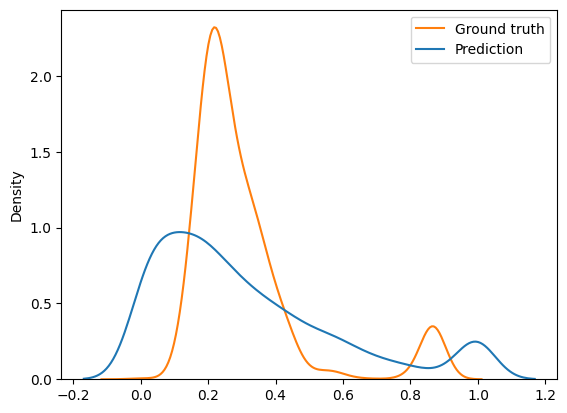

In [30]:
# KDE plot
sns.kdeplot([ground_truth, prediction])
plt.legend(["Ground truth", "Prediction"]);

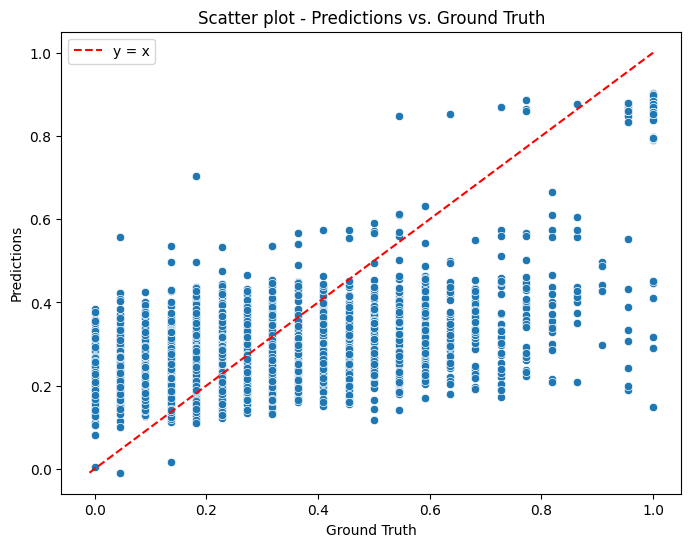

In [31]:
# Scatter plot

# Create a diagonal line for y = x
x_values = np.linspace(
    min(prediction.min(), ground_truth.min()),
    max(prediction.max(), ground_truth.max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth, y=prediction)

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Ground Truth")

plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()